# importing libraries

In [2]:
import os
import pandas as pd
os.environ["AICORE_AUTH_URL"] = "https://btp-ai-developments-sl2f9ys4.authentication.eu10.hana.ondemand.com"
os.environ["AICORE_CLIENT_ID"] = "sb-38176009-b499-470f-a3b8-9cf98daac1d0!b503699|aicore!b540"
os.environ["AICORE_CLIENT_SECRET"] = "1ac5c77f-d5ac-4e2d-8c19-6ffc47113ec8$52U4q9NYAN-GBm23a2lm_SFVrzmWNhuS7l_qFXs4s4A="
os.environ["AICORE_BASE_URL"] = "https://api.ai.prod.eu-central-1.aws.ml.hana.ondemand.com"
os.environ["AICORE_RESOURCE_GROUP"]="default"
os.environ["TAVILY_API_KEY"] = "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"

# defining llm

In [3]:
from gen_ai_hub.proxy.langchain.init_models import init_llm
llm_model = init_llm('gpt-4o', max_tokens=10000, temperature = 0)

In [4]:
from langchain_community.utilities import SQLDatabase
from sqlalchemy import create_engine,inspect,text
from langchain.chains import create_sql_query_chain
from urllib.parse import quote_plus

## configuring database instance
host = "cfe32093-429a-4e59-87dc-9f3e4da891bf.hna2.prod-eu10.hanacloud.ondemand.com"
port = "443"
# schema_name = "INVT_XAI"
schema_name = "INVT_XAI_RAW"
user = "DBADMIN"
password = "Bcone@1234567"

## Encode user and password
user_enc = quote_plus(user)
password_enc = quote_plus(password)

# Connecting to S4 HANA DB:
connection_str = f"hana://{user_enc}:{password_enc}@{host}:{port}/?currentSchema={schema_name}"
engine = create_engine(connection_str)


# defining tools for reasoning agent

In [5]:
def df_to_chat_response_overstock(llm_model, df_stock_status_alert ):

    """generates overstock reasoning for detect overstock scenario"""

    # Ensure 'week_end_date' is in datetime format
    df_stock_status_alert["week_end_date"] = pd.to_datetime(df_stock_status_alert["week_end_date"])
    latest_date = df_stock_status_alert["week_end_date"].max()
    earliest_date = df_stock_status_alert["week_end_date"].min()

    # Filter rows for the latest available week
    filtered_alerts = df_stock_status_alert[df_stock_status_alert["week_end_date"] == latest_date]

    # Convert dataframes to string for prompt context
    # stock_data_str = filtered_alerts.to_string(index=False) if not filtered_alerts.empty else "No stock data available."
    stock_data_str = df_stock_status_alert.to_string(index=False) if not df_stock_status_alert.empty else "No stock data available."

    prompt = f"""
You are an expert in Inventory Planning.

Your task is to provide L1 (level one) and L2 (level two) reason for inventory imbalance specifically overstock instances at the (product_id, location_id) level using the data provided.
L1 is the primary reason by which overstock has occured. While L2 reason provides the cause behind the L1 reason.
Use only the provided data: df_stock_status_alert

- Start Date: {earliest_date.date()}
- End Date: {latest_date.date()}

Important instructions-
- Include Start Date and End Date in the Alert generated.
- Strictly avoid assumptions or generic explanations. All insights must be grounded in the provided data.
- Use data as evidence to showcase your summary of reasoning for overstock patterns in L2 Reasons.
- Verify that every statement is directly supported by data followed by your conclusion on that data and logic.
- Thus, Data evidence and should explained step wise in the output filed - 'Chain of thought'
- There can be single or multiple L1 and L2 reasons. Thus, It is important to mention all the applicable L1 and L2 reasons


Explanation Guidelines:
- Focus only on instance weeks data from df_stock_status_alert.
- The alert must be based on one unique (product_id, location_id) instance.
Supply Chain Flow: VEN ➝ Plant ➝ RDC ➝ DC  

Here are the column dictionary for df_stock_status_alert:
- Column Name (Data Type): column description
- product_id(varchar): Unique identifier of the product (e.g., FG-1000, FG-2000).
- location_id(varchar): Identifier of the distribution center (e.g., DC1000, RDC1000).
- week_num(integer): An integer (1-52) representing the ISO week number of the year.
- week_end_date (date): Date (ISO format) representing the last day (typically Sunday) of the given week_num and year.
- quarter (varchar): Calendar quarter (e.g., Q1, Q2) corresponding to the week_end_date.
- month (varchar): Full month name (e.g., January, February) derived from the week_end_date.
- year (integer): Four-digit calendar year associated with the week_num.
- stock_condition (varchar): Indicates the comparison between projected_stock and safety_stock.
Values:
excess: when projected_stock > safety_stock
deficit: when projected_stock < safety_stock
in-stock: when projected_stock == safety_stock
- stock_status_warning (varchar): Alerts when 4 or more consecutive weeks of excess or deficit are detected for a given product_id, location_id, and location_type.
Values:
normal: No warning condition detected
overstock_instance_N: Nth occurrence of a prolonged excess stock condition
understock_instance_N: Nth occurrence of a prolonged deficit stock condition
In response, keep in mind to mention Nth occurrence of condition only once 
While responding with instance occurrence, don't mention instances verbatim (like overstock_instance_1) , mention it in more natural language format.
- transportation_lead_time(integer): time (in weeks) required for traversal of a product from RDC to the DC
- minimum_transportation(integer): minimum number of units that can be transported to the current location
- incremental_transportation(integer): additional minimum incremental units that can be added to minimum transportation unit to transport more units to the current location
- production_lead_time(integer): time (in weeks) required for the production of the good
- offset_stock(integer): difference between projected stock and safety stock that signifies amount of stock at the end of the week
- lag_1_dependent_demand: These are depedent demand value predicted a week prior to current prediction data	
- lag_1_supply_orders: These are supply order value predicted a week prior to current prediction data	
- ven_300_001_maximum_external_receipt: the unit of supply by provided by Vendor 'VEN-300-001'. This vendor specifically supplies for product 'FG-300-001'.

Alert explanation must follow this format template:
{{
"Alert": "Excess observed for product_id FG-100-001 and location_id DC1000 during 2026-07-05 to 2026-07-05",
"Chain of thought": "Step 1. The overstock instance starts from  2026-07-05 to 2026-07-05. Step 2.The stock on hand value for the first week 0.That means value for first week 'stock on hand' for the instance doesn't exist. Thus,L1 reason is not related to stock hand. Step 3. As the previous step did not succeed this step is not applicable. Proceed to next step.........<completeing all steps>.I have gone through and concluded on all 11 steps as instructed. Thus,there 2 applicable reasons for this instance."
"Reason 1": {{
"L1 Reason": "Larger Lot Size",
"L2 Reason": "At the beginning of the overstock period , the stock on hand was 800 units, which is significantly higher than the safety stock of 100 units.The production lead time is 6 weeks, which is longer than the duration of the overstock instance (9 weeks). This longer production lead time in the production plant resulted in maintaining high stock on hand to support lead time horizon demand.",
"Priority": "High"
}},
"Reason 1": {{
"L1 Reason": "Overforecasting Demand",
"L2 Reason": " The current demand and the prior demand values are .....<corresponding reasoning showcase as instructed>.",
"Priority": "Medium"
}}
}}

Prcoess to find L1 and L2 Reasons fo overstock, going step by step:
        Step 1. First look at that individual instance of overstock and confirm the checks given in subsequent steps. Based on the confirmed checks, provide all the passed check-wise L1 and L2 reasons as instructed.
        Step 2. Find the 'stock on hand' value for the first week of the instance period i.e. the first week of the instance and check If 'stock on hand' value greater than 0
        Step 3. If check succeeds then check if the value is greater than 'safety stock' value for the same week (i.e. first week of the instance)
        Step 4. If the check is true then respond that the cause of overstock is because of high amount of 'stock on hand' at the start of the period as L1 (Level 1) reason
        Step 5. For (Level 2) L2 reason check 'transportation lead time' first and later 'production lead time' 
        sub step 1 - if 'transportation lead time' is less than 3 weeks short than the duration (number of weeks i.e. records) in the overstock instance then say L2 reason as Longer Transportation Lead Time travel to the location resulted in High Stock on Hand to support Lead Time Horizon Demand.
        sub step 2 - If 'transportation lead time' is more than 3 weeks short than the instance duration then check if 'production lead time' is less than 3 weeks short than the duration (number of weeks i.e. records). If 'production lead time' qualifies the check then say the L2 reason as Longer Production Lead Time in the Production Plant, High Stock on Hand to support Lead Time Horizon Demand.
        sub step 3 - If both of the sub steps checks fails, then see if the addition of  'transportation lead time' and 'production lead time' is more than 3 weeks short than the instance duration. If check passes then say L2 reason as Longer Production Lead time and Transportation Lead Time travel to the location combined resulted in High Stock on Hand to support Lead Time Horizon Demand.
        Step 6. If 'stock on hand' value greater than 0 check failed then check if 'incoming receipts' for first week of the instance period has value greater than 'total demand'
        Step 7. If check is true, then say that L1 reason as Larger lot size is the reason for overstocking 
        sub step 1 - For gain L2 reason, check if any present values of 'incoming receipts' has value as added multiples of 'incremental transportation' value to 'minimum transportation'(e.g. 'minimum transportation' 600 + n* 'incremental transportation' 100 -> 700,800,900,etc )  
        sub step 2 - If check is true, then say that L2 reason for overstocking is as Demand is lesser than Rounding Transportation Lot Size 
        sub step 3 - If check fails, then check if all present values of 'incoming receipts' for the instance duration is exactly same as 'minimum transportation' (i.e. Minimum Transportation Lot Size)
        sub step 4 - if above check is true then say that L2 reason for overstocking is as Demand is lesser than Minimum Transportation Lot Size
        Step 8. Irrespective of all above check fails or pass, check if 'total demand' is same as 'lag_1_dependent_demand' for the instance by comparing sum of their values for the duration with each other
        Step 9. If the sum values are different, and the difference shows that  'lag_1_dependent_demand' was higher than 'total demand' sum, that means that the decrease in demand in the current scene as compared to prediction of prior week demand is the reason for understocking. Thus, making L1 reason as Under forecasting Demand and L2 reason as Demand Spike in the Lead Time Horizon compared to last week.
        Step 10. if multiple checks are passed while following previous steps, then make sure to specify all the corresponding L1 and L2 reasons as the cause for the instance
        Step 11. If all the checks in all previous step fails then say the reason for overstock is supply chain management

L2 Reason must include two parts:
- A brief explanation of the L1 reason using current evidence data over the weeks of instance duration  
- Support using data values to your explaination

Data:
- df_stock_status_alert (latest week only):\n{stock_data_str}\n

Only respond with a JSON block of one alert explanation.
"""

# **Return only one alert per unique L1 reason. Do not repeat the same L1 reason across different weeks. Return a minimum of 1 and a maximum of 3 such alerts.**


    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": "Provide concise root cause analysis for each (product_id, location_id) alert using JSON format."}
    ]

    try:
        response = llm_model.invoke(messages)
        return response.content.strip()
    except Exception as e:
        print(f"Error while getting response from LLM: {e}")
        return "LLM failed to generate explanation."



# creating a seperate pipline for understock
def df_to_chat_response_understock(llm_model, df_stock_status_alert ):

    """generates understock reasoning for detect understock scenario"""
    # Ensure 'week_end_date' is in datetime format
    df_stock_status_alert["week_end_date"] = pd.to_datetime(df_stock_status_alert["week_end_date"])
    latest_date = df_stock_status_alert["week_end_date"].max()
    earliest_date = df_stock_status_alert["week_end_date"].min()

    # Filter rows for the latest available week
    filtered_alerts = df_stock_status_alert[df_stock_status_alert["week_end_date"] == latest_date]

    # Convert dataframes to string for prompt context
    # stock_data_str = filtered_alerts.to_string(index=False) if not filtered_alerts.empty else "No stock data available."
    stock_data_str = df_stock_status_alert.to_string(index=False) if not df_stock_status_alert.empty else "No stock data available."

    prompt = f"""
You are an expert in Inventory Planning.

Your task is to provide L1 (level one) and L2 (level two) reason for inventory imbalance specifically understock instances at the (product_id, location_id) level using the data provided.
L1 is the primary reason by which understock has occured. While L2 reason provides the cause behind the L1 reason.
Use only the provided data: df_stock_status_alert

- Start Date: {earliest_date.date()}
- End Date: {latest_date.date()}

Important instructions-
- Include Start Date and End Date in the Alert generated.
- Strictly avoid assumptions or generic explanations. All insights must be grounded in the provided data.
- Use data as evidence to showcase your reasoning for understock patterns in L2 Reasons.
- Verify that every statement is directly supported by data followed by your conclusion on that data and logic.
- Thus, Data evidence and should explained step wise in the output filed - 'Chain of thought'
- There can be single or multiple L1 and L2 reasons. Thus, It is important to mention all the applicable L1 and L2 reasons


Explanation Guidelines:
- Focus only on instance weeks data from df_stock_status_alert.
- The alert must be based on one unique (product_id, location_id) instance.
Supply Chain Flow: VEN ➝ Plant ➝ RDC ➝ DC  

Here are the column dictionary for df_stock_status_alert:
- Column Name (Data Type): column description
- product_id(varchar): Unique identifier of the product (e.g., FG-1000, FG-2000).
- location_id(varchar): Identifier of the distribution center (e.g., DC1000, RDC1000).
- week_num(integer): An integer (1-52) representing the ISO week number of the year.
- week_end_date (date): Date (ISO format) representing the last day (typically Sunday) of the given week_num and year.
- quarter (varchar): Calendar quarter (e.g., Q1, Q2) corresponding to the week_end_date.
- month (varchar): Full month name (e.g., January, February) derived from the week_end_date.
- year (integer): Four-digit calendar year associated with the week_num.
- stock_condition (varchar): Indicates the comparison between projected_stock and safety_stock.
Values:
excess: when projected_stock > safety_stock
deficit: when projected_stock < safety_stock
in-stock: when projected_stock == safety_stock
- stock_status_warning (varchar): Alerts when 4 or more consecutive weeks of excess or deficit are detected for a given product_id, location_id, and location_type.
Values:
normal: No warning condition detected
overstock_instance_N: Nth occurrence of a prolonged excess stock condition
understock_instance_N: Nth occurrence of a prolonged deficit stock condition
In response, keep in mind to mention Nth occurrence of condition only once 
While responding with instance occurrence, don't mention instances verbatim (like overstock_instance_1) , mention it in more natural language format.
- transportation_lead_time(integer): time (in weeks) required for traversal of a product from RDC to the DC
- minimum_transportation(integer): minimum number of units that can be transported to the current location
- incremental_transportation(integer): additional minimum incremental units that can be added to minimum transportation unit to transport more units to the current location
- production_lead_time(integer): time (in weeks) required for the production of the good
- offset_stock(integer): difference between projected stock and safety stock that signifies amount of stock at the end of the week
- lag_1_dependent_demand: These are depedent demand value predicted a week prior to current prediction data	
- lag_1_supply_orders: These are supply order value predicted a week prior to current prediction data	
- ven_300_001_maximum_external_receipt: the unit of supply by provided by Vendor 'VEN-300-001'. This vendor specifically supplies for product 'FG-300-001'.


Alert explanation must follow this format:

{{
"Alert": "Deficit observed for product_id FG-100-001 and location_id DC1000 during 2025-08-24 to 2025-10-19",
"Chain of thought": "Step 1. The understock instance starts from  2025-08-24 to 2025-10-19. Step 2.All the incoming reciepts for the instance suration is zero.Step 2. Thus, The check fails. Thus one of the L1 reason is longer lead time. Proceed to next step.........<completeing all steps>.I have gone through and concluded on all 10 steps as instructed. Thus,there 2 applicable reasons for this instance. "
"Reason 1": {{
"L1 Reason": "Longer Lead Time",
"L2 Reason": "Throughout the period from week 34 to 42, there were no incoming receipts for the majority of the weeks, except for weeks 40 and 41 where incoming receipts were recorded as 500 units. This indicates a prolonged period without sufficient supply.Furthermore, The transportation lead time is consistently 8 weeks, which is significant and suggests delays in the movement of goods from the regional distribution center to the distribution center. This extended transportation lead time is a contributing factor to the understock condition",
"Priority": "High"
}},
"Reason 2": {{
"L1 Reason": "Supplier Delays",
"L2 Reason": "Throughout the period from week 34 to 42 ....... <corresponding reasoning showcase as instructed>.",
"Priority": "Medium"
}}
}}

Prcoess to find L1 and L2 Reasons fo understock, going step by step:
        Step 1. First look at that individual instance of understock and confirm the checks given in subsequent steps. Based on the confirmed checks, provide all the passed check-wise L1 and L2 reasons as instructed.
        Step 2. Check if there exists any value greater than 0 in 'incoming receipts' for that instance period.
        Step 3. If the check is False then say L1 reason is Longer Lead time
        sub step 1. For L2 reasoning, check if 'transportation lead time' greater than 1. if check is true then say L2 reason is Longer Transportation Lead Time Between RDC & DC
        sub step 2. Now if sub step 1 check fails check if 'production lead time' is greater than 1. If check is true then say L2 reason Longer Production Lead Time in the Production Plant
        Step 4. Irrespective of all above check fails or pass, Check if 'total demand' is same as 'lag_1_dependent_demand' for the instance by comparing sum of their values for the duration with each other
        Step 5. If the sum values are different, and the difference shows that  'lag_1_dependent_demand' was lower than 'total demand' sum, that means that the increase in demand in the current scene as compared to prediction of prior week demand is the reason for understock. Thus, making L1 reason as Underforecasting Demand and L2 reason as Demand Spike in the Lead Time Horizon compared  to Last week.
        Step 6. If all above check fails then check if the product is 'FG-300-001' and check if values exists for ven_300_001_maximum_external_receipt for that product for the intance duration
        Step 7. If values all values are '0' for the instance duration then it means that vendor with id 'VEN-300-001' has stopped supply for the product 'FG-300-001' for that duration and making L1 reason as Supplier Delays and L2 reason as Supplier Capacity Constraints
        Step 8. Irrespective of all above check fails or pass, Check is if there are non zero 'supply order' values for the instance duration.
        Step 9. If the previous check is true, then if check if 'supply order' values are different than 'lag_1_supply_order' values. If check is true that means supply orders made by the manager were changed in the current scene.Thus say that L1 reason is Transportation delays and L2 reason as Delayed Purchase Orders.
        Step 11. If all the checks in all previous step fails then say the reason for understock is supply chain management   

L2 Reason must include two parts:
- A brief explanation of the L1 reason using current evidence data over the weeks of instance duration  
- Support using data values to your explaination

Data:
- df_stock_status_alert :\n{stock_data_str}\n

Only respond with a JSON block of one alert explanation.
"""

# **Return only one alert per unique L1 reason. Do not repeat the same L1 reason across different weeks. Return a minimum of 1 and a maximum of 3 such alerts.**


    messages = [
        {"role": "system", "content": prompt},
        {"role": "user", "content": "Provide concise root cause analysis for each (product_id, location_id) alert using JSON format."}
    ]

    try:
        response = llm_model.invoke(messages)
        return response.content.strip()
    except Exception as e:
        print(f"Error while getting response from LLM: {e}")
        return "LLM failed to generate explanation."





In [8]:
from langgraph.prebuilt import create_react_agent


reasoning_agent = create_react_agent(
    model=llm_model,
    tools=[df_to_chat_response_overstock, df_to_chat_response_understock],
    prompt=(
        """
        Your task is to extract product ID , Location ID and time data like week number with year or complete date from the query the user has asked. 
        Details of the fields are - 
        - product_id(varchar): Unique identifier of the product (e.g., FG-100-001, FG-200-001).
        - location_id(varchar): Identifier of the distribution center (e.g., DC1000, RDC1000).
        - week_num(integer): An integer (1-52) representing the ISO week number of the year.
        - year (integer): Four-digit calendar year associated with the week_num.
        - week_end_date (date): Date (ISO format) representing the last day (typically Sunday) of the given week_num and year.

        Instructions:
        - First identify the said values and then strictly respond in provided sample format. 
        - If any of the value is not present then respond its value as "Not provided by user"
        - If there are multiple dates then provide the one that is the earliest.
        - If week number is provided, make sure you also extract year value from the query along with week value 
        Sample Response format 1 -
        {
            "product_id" : "FG-100-001",
            "location_id": "DC2000",
            "week_num" : 30,
            "year": 2025,
            "week_end_date" :  "Not provided by user"
        }
        Sample Response format 2 -
        {
            "product_id" : "FG-100-001",
            "location_id": "DC2000",
            "week_num" : "Not provided by user",
            "year": "Not provided by user",
            "week_end_date" :  "2025-07-27"
        }

        Post detection, generate reasonings by calling the tools
"""

    ),
    name="reasoning_agent",
)

In [9]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [10]:
for chunk in reasoning_agent.stream(
    {"messages": [{"role": "user", "content": "What is the reason for the Overstock instance for product FG-100-001 at location DC2000 starting from week 43 2025?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: reasoning_agent

{
    "product_id" : "FG-100-001",
    "location_id": "DC2000",
    "week_num" : 43,
    "year": 2025,
    "week_end_date" :  "Not provided by user"
}
Tool Calls:
  df_to_chat_response_overstock (call_Cb0AQq7yXLZ0dxQuU7BehUXF)
 Call ID: call_Cb0AQq7yXLZ0dxQuU7BehUXF
  Args:
    llm_model: gpt-4
    df_stock_status_alert: {'product_id': 'FG-100-001', 'location_id': 'DC2000', 'week_num': 43, 'year': 2025}


Update from node tools:


================================= Tool Message =================================
Name: df_to_chat_response_overstock

Error: KeyError('week_end_date')
 Please fix your mistakes.


Update from node agent:


================================== Ai Message ==================================
Name: reasoning_agent

It seems there was an issue due to the missing `week_end_date` in the provided data. Let me correct this and try again.
Tool 

In [7]:
os.environ["TAVILY_API_KEY"] = "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"
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("who is the mayor of NYC?")

print(web_search_results["results"][0]["content"])

Mayor of New York City - Wikipedia Mayor of New York City | Mayor of the City of New York | | Image 5 Standard of the mayor of New York City | | Deputy | First Deputy Mayor of New York City | The mayor of New York City may appoint several deputy mayors to help oversee major offices within the executive branch of the city government. Image 8It has been suggested that this section be split out into another article titled _List of former deputy mayors of New York City")_. _To be mayor of New York: Ethnic politics in the city_ (Columbia University Press, 1993) online; covers 1881–1989. *   Mayors of New York City Mayor of New York City


In [12]:
research_agent = create_react_agent(
    model = llm_model,
    tools=[web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [15]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=llm_model,
    agents=[reasoning_agent, research_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a reasoning agent. Assign reasoning-related tasks to this agent\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

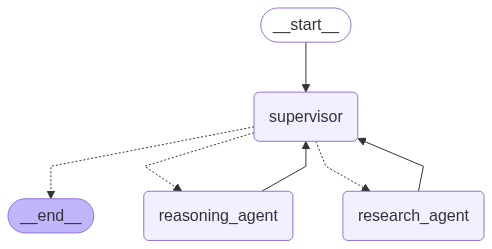

In [16]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [17]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_reasoning_agent

Successfully transferred to reasoning_agent


Update from node reasoning_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

The estimated GDP for the United States in 2024 is $26.9 trillion, and New York State's GDP

In [18]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is the reason for the Overstock instance for product FG-100-001 at location DC2000 starting from week 43 2025?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_reasoning_agent

Successfully transferred to reasoning_agent


Update from node reasoning_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

The reasoning agent has identified the product ID as "FG-100-001," the location as "DC2000," and the overstock issue starting from week 43 in the year 2025. However, additional details such as the week-end date or specific inventory data might be required to determine the exact cause.

Should I assign the research agent to gather more information about inventory levels, demand forecasts, or other relevant data?


